In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime
from datetime import timedelta
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Base de Datos

In [2]:
# Se carga la base de datos.

datos = pd.read_csv("JamesHarden19-20.csv")
print(datos)

     Rk   G        Date     Age   Tm Unnamed: 5  Opp Unnamed: 7  GS     MP  \
0     1   1  2017-10-17  28-052  HOU          @  GSW     W (+1)   1  36:24   
1     2   2  2017-10-18  28-053  HOU          @  SAC     W (+5)   1  37:46   
2     3   3  2017-10-21  28-056  HOU        NaN  DAL    W (+16)   1  30:45   
3     4   4  2017-10-23  28-058  HOU        NaN  MEM     L (-8)   1  35:08   
4     5   5  2017-10-25  28-060  HOU          @  PHI     W (+1)   1  41:26   
..   ..  ..         ...     ...  ...        ...  ...        ...  ..    ...   
216  71  67  2020-08-12  30-352  HOU        NaN  IND     L (-4)   1  35:28   
217  72  68  2020-08-14  30-354  HOU        NaN  PHI    L (-38)   1  26:17   
218   1   1  2020-12-26  31-122  HOU          @  POR     L (-2)   1  43:16   
219   2   2  2020-12-28  31-124  HOU          @  DEN    L (-13)   1  31:29   
220   3   3  2020-12-31  31-127  HOU        NaN  SAC     W (+3)   1  38:18   

     ...  DRB  TRB  AST  STL  BLK  TOV  PF  PTS  GmSc  +/-  
0 

In [3]:
# Se guardan los datos en la variable casos y se reajusta para el modelo LSTM con reshape.

dataset = datos.values
pts = dataset[:,27]
print(pts.shape)
pts2 = pts.reshape(-1,1)
print(pts2.shape)

(221,)
(221, 1)


In [4]:
# Visualizacion de Datos
        
for i in range(0, len(pts2)):
    print(pts2[i])

[27]
[27]
[29]
[22]
[27]
[27]
[20]
[29]
[31]
[29]
[56]
[35]
[38]
[26]
[38]
[48]
[29]
[21]
[37]
[37]
[29]
[36]
[29]
[48]
[26]
[21]
[28]
[31]
[26]
[51]
[51]
[29]
[34]
[20]
[40]
[10]
[22]
[28]
[25]
[23]
[27]
[60]
[28]
[16]
[36]
[41]
[28]
[27]
[34]
[28]
[31]
[41]
[26]
[25]
[26]
[23]
[26]
[40]
[28]
[24]
[32]
[34]
[42]
[21]
[27]
[18]
[28]
[25]
[38]
[24]
[26]
[21]
[18]
[36]
[31]
[29]
[25]
[28]
[19]
[25]
[40]
[22]
[27]
[34]
[43]
[33]
[40]
[54]
[25]
[23]
[30]
[29]
[15]
[35]
[29]
[50]
[32]
[47]
[35]
[35]
[39]
[41]
[45]
[41]
[43]
[44]
[38]
[32]
[42]
[43]
[38]
[57]
[58]
[48]
[37]
[61]
[35]
[40]
[37]
[30]
[43]
[44]
[36]
[42]
[31]
[42]
[30]
[28]
[30]
[58]
[42]
[35]
[31]
[20]
[28]
[29]
[41]
[20]
[31]
[57]
[61]
[28]
[23]
[38]
[50]
[36]
[31]
[26]
[30]
[39]
[19]
[29]
[40]
[59]
[36]
[29]
[44]
[36]
[42]
[39]
[47]
[44]
[49]
[36]
[27]
[37]
[32]
[34]
[60]
[50]
[23]
[34]
[27]
[55]
[54]
[39]
[28]
[28]
[47]
[34]
[24]
[44]
[35]
[44]
[41]
[17]
[32]
[41]
[13]
[34]
[29]
[27]
[12]
[18]
[35]
[40]
[40]
[14]
[32]
[28]


In [5]:
# fechas = np.array([datetime.datetime(2020, 3, 2) + timedelta(days=i) for i in range(len(casos2))])

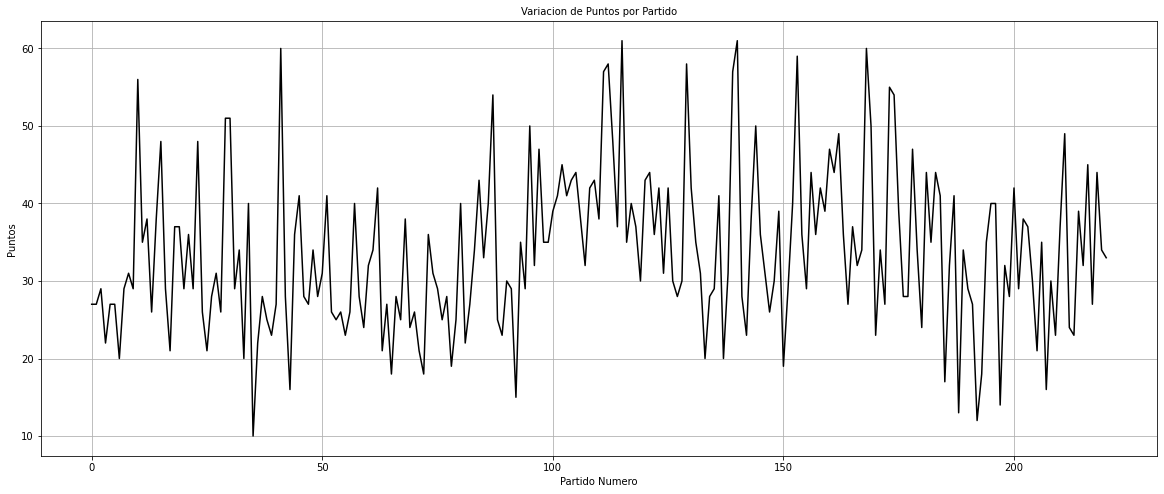

In [6]:
plt.figure(figsize=[20,8])
plt.grid()
plt.plot(pts, '-k')
plt.xlabel("Partido Numero",fontsize = 10)
plt.ylabel("Puntos",fontsize = 10)
plt.title("Variacion de Puntos por Partido", fontsize = 10)
plt.savefig("FigOriginal.png")

(221, 1)


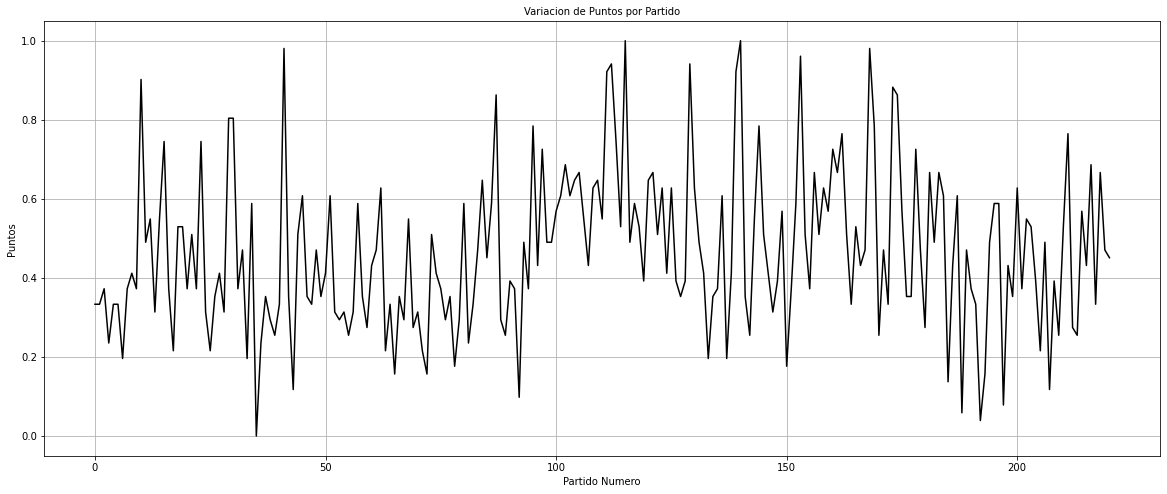

In [7]:
# Se normaliza entre 0 y 1 el dataset.

scaler = MinMaxScaler(feature_range=(0, 1))
pts_totales = scaler.fit_transform(pts2)
print(pts_totales.shape)
plt.figure(figsize=[20,8])
plt.grid()
plt.plot(pts_totales, '-k')
plt.xlabel("Partido Numero",fontsize = 10)
plt.ylabel("Puntos",fontsize = 10)
plt.title("Variacion de Puntos por Partido", fontsize = 10)
plt.savefig("FigOriginal.png")

# Generacion de Conjuntos de Datos

In [8]:
# Se generar los conjuntos de Entrenamiento (Train), Validacion (Val) y de Test.
porcentaje = 0.8
train_size = int(len(pts_totales) * porcentaje)
test_size = len(pts_totales) - train_size
train, test = pts_totales[0:train_size,:], pts_totales[train_size:len(pts_totales),:]

print("Los conjuntos quedan: Train:", len(train), ", Test: ", len(test))

# val
porcentaje = 0.65
train_size1 = int(len(train) * porcentaje)
val_size = len(train) - train_size1
train, val = train[0:train_size1,:], train[train_size1:len(pts_totales),:]

print("Los conjuntos quedan: Train:", len(train), ", Val: ", len(val),  ", Test: ", len(test))

Los conjuntos quedan: Train: 176 , Test:  45
Los conjuntos quedan: Train: 114 , Val:  62 , Test:  45


In [9]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [10]:
n_steps_in = 5  # ventana de n datos de entrada 
n_steps_out = 1  # n predicciones 
n_features = 1   # solo un feature (no cambiar en este ejemplo)

trainX, trainY = split_sequence(train, n_steps_in, n_steps_out)   # generamos la división
valX, valY = split_sequence(val, n_steps_in, n_steps_out)
testX, testY = split_sequence(test, n_steps_in, n_steps_out)

for i in range(1):
    print("Datos de entrada:")
    print(trainX[i])
    print()
    print("Etiqueta:")
    print(trainY[i])
    print()

Datos de entrada:
[[0.33333333]
 [0.33333333]
 [0.37254902]
 [0.23529412]
 [0.33333333]]

Etiqueta:
[[0.33333333]]



In [11]:
# Se transforma el formato de las Etiquetas a la requerida por la LSTM.

trainY = np.reshape(trainY, (trainY.shape[0],trainY.shape[1]))
valY = np.reshape(valY, (valY.shape[0],valY.shape[1]))
testY = np.reshape(testY, (testY.shape[0],testY.shape[1]))

print("Train:", trainY.shape, ", Val:", valY.shape, ", Test:", testY.shape)

Train: (109, 1) , Val: (57, 1) , Test: (40, 1)


# Modelo de RNN LSTM

In [12]:
# Se define el Modelo LSTM y sus parametros.

# network
output_dim= 100

def modelo_lstm():
    model = Sequential()
    model.add(LSTM(output_dim, activation='sigmoid', input_shape=(n_steps_in, n_features)))
#     model.add(Dense(300, activation='relu'))
#     model.add(Dense(200, activation='relu'))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(8, activation='sigmoid'))
    model.add(Dense(n_steps_out))
    model.compile(loss='mae', optimizer='adam', metrics=['mse', 'mae'])
    return model

batch_size= 32
epochs= 500

model = modelo_lstm()
model.summary()
start = time.time()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 50,017
Trainable params: 50,017
Non-trainable params: 0
____________________________________________________

In [13]:
# Se entrena el Modelo.

history = model.fit(trainX, trainY, batch_size=batch_size, epochs= epochs, validation_data=(valX,valY))

print("> tiempro entrenando... : ", time.time() - start)

Epoch 1/500
4/4 [==============================] - 0s 85ms/step - loss: 0.5989 - mse: 0.3975 - mae: 0.5989 - val_loss: 0.6367 - val_mse: 0.4485 - val_mae: 0.6367
Epoch 2/500
4/4 [==============================] - 0s 7ms/step - loss: 0.5187 - mse: 0.3076 - mae: 0.5187 - val_loss: 0.5565 - val_mse: 0.3528 - val_mae: 0.5565
Epoch 3/500
4/4 [==============================] - 0s 7ms/step - loss: 0.4390 - mse: 0.2307 - mae: 0.4390 - val_loss: 0.4768 - val_mse: 0.2703 - val_mae: 0.4768
Epoch 4/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3603 - mse: 0.1670 - mae: 0.3603 - val_loss: 0.3980 - val_mse: 0.2014 - val_mae: 0.3980
Epoch 5/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2864 - mse: 0.1168 - mae: 0.2864 - val_loss: 0.3243 - val_mse: 0.1464 - val_mae: 0.3243
Epoch 6/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2227 - mse: 0.0807 - mae: 0.2227 - val_loss: 0.2621 - val_mse: 0.1053 - val_mae: 0.2621
Epoch 7/500
4/4 [================

4/4 [==============================] - 0s 7ms/step - loss: 0.1553 - mse: 0.0426 - mae: 0.1553 - val_loss: 0.2001 - val_mse: 0.0708 - val_mae: 0.2001
Epoch 52/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1553 - mse: 0.0434 - mae: 0.1553 - val_loss: 0.1980 - val_mse: 0.0695 - val_mae: 0.1980
Epoch 53/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1551 - mse: 0.0426 - mae: 0.1551 - val_loss: 0.1947 - val_mse: 0.0675 - val_mae: 0.1947
Epoch 54/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1549 - mse: 0.0420 - mae: 0.1549 - val_loss: 0.1931 - val_mse: 0.0665 - val_mae: 0.1931
Epoch 55/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1549 - mse: 0.0416 - mae: 0.1549 - val_loss: 0.1910 - val_mse: 0.0653 - val_mae: 0.1910
Epoch 56/500
4/4 [==============================] - ETA: 0s - loss: 0.1689 - mse: 0.0482 - mae: 0.168 - 0s 7ms/step - loss: 0.1549 - mse: 0.0411 - mae: 0.1549 - val_loss: 0.1891 - val_mse: 0.0641 - val_m

Epoch 101/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1550 - mse: 0.0394 - mae: 0.1550 - val_loss: 0.1828 - val_mse: 0.0595 - val_mae: 0.1828
Epoch 102/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1551 - mse: 0.0393 - mae: 0.1551 - val_loss: 0.1822 - val_mse: 0.0591 - val_mae: 0.1822
Epoch 103/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1551 - mse: 0.0392 - mae: 0.1551 - val_loss: 0.1817 - val_mse: 0.0588 - val_mae: 0.1817
Epoch 104/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1552 - mse: 0.0393 - mae: 0.1552 - val_loss: 0.1829 - val_mse: 0.0596 - val_mae: 0.1829
Epoch 105/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1553 - mse: 0.0393 - mae: 0.1553 - val_loss: 0.1820 - val_mse: 0.0589 - val_mae: 0.1820
Epoch 106/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1552 - mse: 0.0394 - mae: 0.1552 - val_loss: 0.1841 - val_mse: 0.0604 - val_mae: 0.1841
Epoch 107/500
4/4 [===

4/4 [==============================] - 0s 8ms/step - loss: 0.1553 - mse: 0.0390 - mae: 0.1553 - val_loss: 0.1807 - val_mse: 0.0577 - val_mae: 0.1807
Epoch 152/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1554 - mse: 0.0389 - mae: 0.1554 - val_loss: 0.1813 - val_mse: 0.0583 - val_mae: 0.1813
Epoch 153/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1550 - mse: 0.0392 - mae: 0.1550 - val_loss: 0.1839 - val_mse: 0.0603 - val_mae: 0.1839
Epoch 154/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1552 - mse: 0.0395 - mae: 0.1552 - val_loss: 0.1848 - val_mse: 0.0609 - val_mae: 0.1848
Epoch 155/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1551 - mse: 0.0401 - mae: 0.1551 - val_loss: 0.1879 - val_mse: 0.0633 - val_mae: 0.1879
Epoch 156/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1550 - mse: 0.0408 - mae: 0.1550 - val_loss: 0.1914 - val_mse: 0.0655 - val_mae: 0.1914
Epoch 157/500
4/4 [=================

4/4 [==============================] - 0s 7ms/step - loss: 0.1552 - mse: 0.0396 - mae: 0.1552 - val_loss: 0.1833 - val_mse: 0.0598 - val_mae: 0.1833
Epoch 202/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1550 - mse: 0.0394 - mae: 0.1550 - val_loss: 0.1838 - val_mse: 0.0602 - val_mae: 0.1838
Epoch 203/500
4/4 [==============================] - 0s 8ms/step - loss: 0.1550 - mse: 0.0395 - mae: 0.1550 - val_loss: 0.1841 - val_mse: 0.0604 - val_mae: 0.1841
Epoch 204/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1550 - mse: 0.0396 - mae: 0.1550 - val_loss: 0.1846 - val_mse: 0.0608 - val_mae: 0.1846
Epoch 205/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1550 - mse: 0.0397 - mae: 0.1550 - val_loss: 0.1850 - val_mse: 0.0611 - val_mae: 0.1850
Epoch 206/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1551 - mse: 0.0397 - mae: 0.1551 - val_loss: 0.1853 - val_mse: 0.0613 - val_mae: 0.1853
Epoch 207/500
4/4 [=================

Epoch 251/500
4/4 [==============================] - 0s 9ms/step - loss: 0.1548 - mse: 0.0409 - mae: 0.1548 - val_loss: 0.1914 - val_mse: 0.0655 - val_mae: 0.1914
Epoch 252/500
4/4 [==============================] - 0s 9ms/step - loss: 0.1548 - mse: 0.0414 - mae: 0.1548 - val_loss: 0.1939 - val_mse: 0.0670 - val_mae: 0.1939
Epoch 253/500
4/4 [==============================] - 0s 8ms/step - loss: 0.1548 - mse: 0.0421 - mae: 0.1548 - val_loss: 0.1972 - val_mse: 0.0690 - val_mae: 0.1972
Epoch 254/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1551 - mse: 0.0431 - mae: 0.1551 - val_loss: 0.1995 - val_mse: 0.0704 - val_mae: 0.1995
Epoch 255/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1553 - mse: 0.0431 - mae: 0.1553 - val_loss: 0.1941 - val_mse: 0.0671 - val_mae: 0.1941
Epoch 256/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1550 - mse: 0.0417 - mae: 0.1550 - val_loss: 0.1917 - val_mse: 0.0657 - val_mae: 0.1917
Epoch 257/500
4/4 [===

4/4 [==============================] - 0s 7ms/step - loss: 0.1556 - mse: 0.0411 - mae: 0.1556 - val_loss: 0.1915 - val_mse: 0.0655 - val_mae: 0.1915
Epoch 302/500
4/4 [==============================] - 0s 8ms/step - loss: 0.1549 - mse: 0.0413 - mae: 0.1549 - val_loss: 0.1904 - val_mse: 0.0649 - val_mae: 0.1904
Epoch 303/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1549 - mse: 0.0412 - mae: 0.1549 - val_loss: 0.1919 - val_mse: 0.0658 - val_mae: 0.1919
Epoch 304/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1549 - mse: 0.0415 - mae: 0.1549 - val_loss: 0.1922 - val_mse: 0.0660 - val_mae: 0.1922
Epoch 305/500
4/4 [==============================] - 0s 8ms/step - loss: 0.1550 - mse: 0.0417 - mae: 0.1550 - val_loss: 0.1936 - val_mse: 0.0668 - val_mae: 0.1936
Epoch 306/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1554 - mse: 0.0416 - mae: 0.1554 - val_loss: 0.1918 - val_mse: 0.0657 - val_mae: 0.1918
Epoch 307/500
4/4 [=================

Epoch 351/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1550 - mse: 0.0391 - mae: 0.1550 - val_loss: 0.1821 - val_mse: 0.0591 - val_mae: 0.1821
Epoch 352/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1554 - mse: 0.0392 - mae: 0.1554 - val_loss: 0.1819 - val_mse: 0.0589 - val_mae: 0.1819
Epoch 353/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1555 - mse: 0.0399 - mae: 0.1555 - val_loss: 0.1858 - val_mse: 0.0617 - val_mae: 0.1858
Epoch 354/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1550 - mse: 0.0401 - mae: 0.1550 - val_loss: 0.1865 - val_mse: 0.0623 - val_mae: 0.1865
Epoch 355/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1548 - mse: 0.0402 - mae: 0.1548 - val_loss: 0.1873 - val_mse: 0.0628 - val_mae: 0.1873
Epoch 356/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1549 - mse: 0.0403 - mae: 0.1549 - val_loss: 0.1880 - val_mse: 0.0634 - val_mae: 0.1880
Epoch 357/500
4/4 [===

4/4 [==============================] - 0s 7ms/step - loss: 0.1552 - mse: 0.0388 - mae: 0.1552 - val_loss: 0.1823 - val_mse: 0.0592 - val_mae: 0.1823
Epoch 401/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1548 - mse: 0.0394 - mae: 0.1548 - val_loss: 0.1845 - val_mse: 0.0607 - val_mae: 0.1845
Epoch 402/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1552 - mse: 0.0401 - mae: 0.1552 - val_loss: 0.1872 - val_mse: 0.0628 - val_mae: 0.1872
Epoch 403/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1548 - mse: 0.0402 - mae: 0.1548 - val_loss: 0.1861 - val_mse: 0.0620 - val_mae: 0.1861
Epoch 404/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1547 - mse: 0.0399 - mae: 0.1547 - val_loss: 0.1846 - val_mse: 0.0608 - val_mae: 0.1846
Epoch 405/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1548 - mse: 0.0395 - mae: 0.1548 - val_loss: 0.1833 - val_mse: 0.0599 - val_mae: 0.1833
Epoch 406/500
4/4 [=================

4/4 [==============================] - 0s 7ms/step - loss: 0.1550 - mse: 0.0385 - mae: 0.1550 - val_loss: 0.1814 - val_mse: 0.0586 - val_mae: 0.1814
Epoch 451/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1550 - mse: 0.0397 - mae: 0.1550 - val_loss: 0.1894 - val_mse: 0.0644 - val_mae: 0.1894
Epoch 452/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1543 - mse: 0.0414 - mae: 0.1543 - val_loss: 0.1960 - val_mse: 0.0684 - val_mae: 0.1960
Epoch 453/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1546 - mse: 0.0425 - mae: 0.1546 - val_loss: 0.1964 - val_mse: 0.0686 - val_mae: 0.1964
Epoch 454/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1546 - mse: 0.0425 - mae: 0.1546 - val_loss: 0.1942 - val_mse: 0.0673 - val_mae: 0.1942
Epoch 455/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1545 - mse: 0.0416 - mae: 0.1545 - val_loss: 0.1884 - val_mse: 0.0637 - val_mae: 0.1884
Epoch 456/500
4/4 [=================

4/4 [==============================] - 0s 7ms/step - loss: 0.1493 - mse: 0.0371 - mae: 0.1493 - val_loss: 0.1767 - val_mse: 0.0556 - val_mae: 0.1767
> tiempro entrenando... :  19.975404739379883


# Graficos: MSE / MAE / LOSS

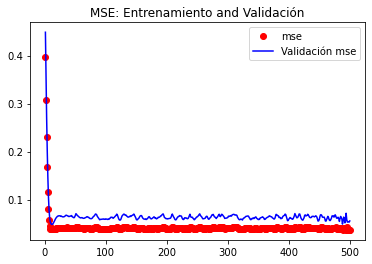

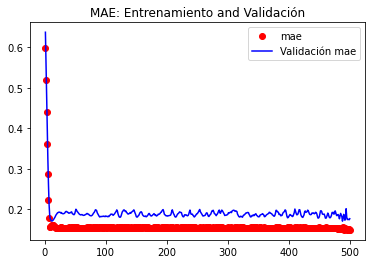

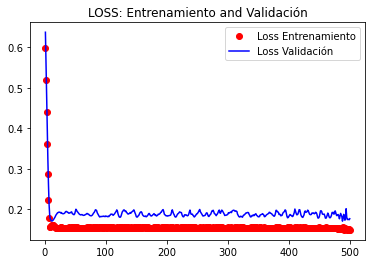

In [14]:
# Gráfico para el MSE obtenido de los datos de la historia
mse = history.history['mse']
val_mse = history.history['val_mse']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse , 'ro', label='mse')
plt.plot(epochs, val_mse , 'b', label='Validación mse')
plt.title('MSE: Entrenamiento and Validación')
plt.legend()
plt.savefig("Fig1.png")

# Gráfico para el MAE obtenido de los datos de la historia
plt.figure()
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae , 'ro', label='mae')
plt.plot(epochs, val_mae , 'b', label='Validación mae')
plt.title('MAE: Entrenamiento and Validación')
plt.legend()
plt.savefig("Fig2.png")

# Gráfico para la pérdida obtenido de los datos de la historia 
plt.figure()
plt.plot(epochs, loss, 'ro', label='Loss Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Loss Validación')
plt.title('LOSS: Entrenamiento and Validación')
plt.legend()
plt.savefig("Fig3.png")
plt.show()

# Predicciones y Puntajes obtenidos

In [15]:
# predicciones de los valores de entrenamiento y prueba 
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

# desnormalizar
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

valPredict = scaler.inverse_transform(valPredict)
valY = scaler.inverse_transform(valY)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [16]:
# Se calcula el RMSE obtenido para cada conjunto de datos.

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.8f RMSE' % (trainScore))

valScore = math.sqrt(mean_squared_error(valY, valPredict))
print('Val Score: %.8f RMSE' % (valScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.8f RMSE' % (testScore))

Train Score: 9.87624376 RMSE
Val Score: 12.02810685 RMSE
Test Score: 9.65554107 RMSE


In [17]:
# Se calcula el MAE promedio y el obtenido para cada conjunto de datos.

print('MAE del entrenamiento promedio: %.8f MAE' % (np.mean(mae)))
print()

trainScore = mean_absolute_error(trainY, trainPredict)
print('Train Score: %.8f MAE' % (trainScore))

valScore = mean_absolute_error(valY, valPredict)
print('Val Score: %.8f MAE' % (valScore))

testScore = mean_absolute_error(testY, testPredict)
print('Test Score: %.8f MAE' % (testScore))

MAE del entrenamiento promedio: 0.15792980 MAE

Train Score: 7.52742764 MAE
Val Score: 9.01198628 MAE
Test Score: 7.93573165 MAE


In [18]:
score = model.evaluate(testX , testPredict)
# print(score)

2/2 [==============================] - 0s 1ms/step - loss: 30.0137 - mse: 901.8508 - mae: 30.0137


# Predicciones futuras

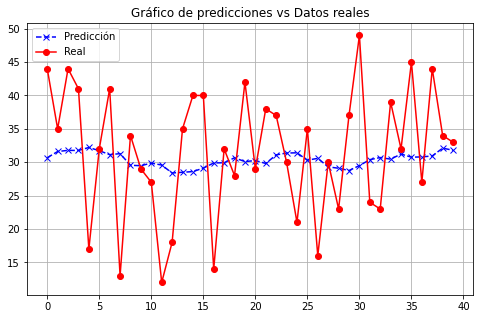

In [19]:
plt.figure(figsize=[8,5])
plt.plot(testPredict ,'b--x', label="Predicción")
plt.plot(testY, 'r-o', label="Real")
plt.grid()
plt.legend(loc='upper left')
plt.title("Gráfico de predicciones vs Datos reales", fontsize = 12)
plt.savefig("FigPrediccionesFuturas.png")

# Revisión de predicciones en toda la curva

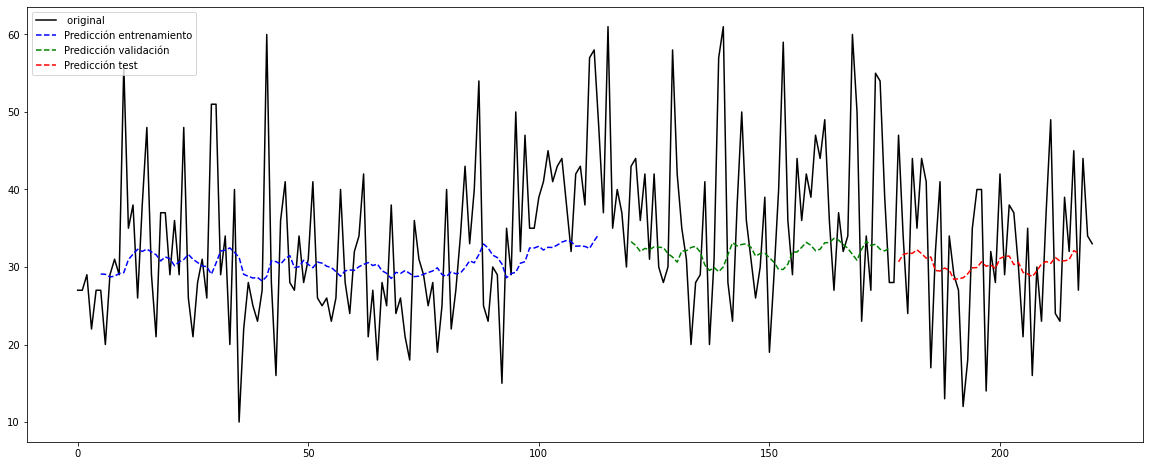

In [20]:
import numpy

trainPredictPlot = numpy.empty_like(pts_totales)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[n_steps_in : len(trainPredict) + n_steps_in, :] = trainPredict

valPredictPlot = numpy.empty_like(pts_totales)
valPredictPlot[:, :] = numpy.nan
valPredictPlot[len(trainPredict) + (n_steps_in*2) + 1 : len(trainPredict) + (n_steps_in*2) + 1 +  len(valPredict) , :] = valPredict

testPredictPlot = numpy.empty_like(pts_totales)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict) + (n_steps_in*2) + 1 + len(valPredict) + 1 : len(pts_totales)-n_steps_in+2 , :] = testPredict

plt.figure(figsize=[20, 8])
plt.plot(scaler.inverse_transform(pts_totales),'k-', label=" original" )
plt.plot(trainPredictPlot, 'b--', label="Predicción entrenamiento")
plt.plot(valPredictPlot, 'g--', label="Predicción validación")
plt.plot(testPredictPlot, 'r--', label="Predicción test")
plt.legend(loc='upper left')
plt.savefig("FigPrediccionesTotal.png")
plt.show()

# Ejemplos de predicción aleatorea

In [23]:
indice = np.random.choice(list(range(len(testX))), 1)[0]
sample = np.reshape(testX[indice], (1, testX.shape[1], testX.shape[2]))
prediccion = model.predict(sample) 
prediccion = scaler.inverse_transform(prediccion)
etiqueta_real = testY[indice]

print("Entrada:")
print(scaler.inverse_transform(testX[indice]))
print()
print("Comparación de una predicción aleatoria:")
print()
print("Valor de la etiqueta real:")
print(etiqueta_real)
print()
print("Valor de la predicción:")
print(prediccion[0])

Entrada:
[[34.]
 [24.]
 [44.]
 [35.]
 [44.]]

Comparación de una predicción aleatoria:

Valor de la etiqueta real:
[41.]

Valor de la predicción:
[31.76423]
